In [2]:
import sys
sys.path.append("../..")
from project_settings import PROJECT_DIRECTORY

from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# g-shape correlation in MassiveBlack

In [4]:
# read in halo catalog
import h5py
filepath = PROJECT_DIRECTORY+'shape_correlations/data/MB2_subfind_z_1.0.hdf5'
f = h5py.File(filepath, 'r')

In [6]:
# get table of halo properties
from astropy.table import Table
data = Table.read(filepath, path='catalog')
for name in data.dtype.names:
    print(name)

halos.subfindId
halos.central
halos.mass
halos.vdisp
halos.vcirc
halos.rcirc
halos.m_gas
halos.m_dm
halos.m_star
halos.m_bh
halos.x
halos.y
halos.z
halos.vx
halos.vy
halos.vz
groups.groupId
groups.subfindId
groups.mass
groups.m_gas
groups.m_dm
groups.m_star
groups.m_bh
groups.x
groups.y
groups.z
groups.vx
groups.vy
groups.vz
prop.sfr
prop.btr
prop.SDSS_g
prop.SDSS_i
prop.SDSS_r
prop.SDSS_u
prop.SDSS_z
shapesDM.q3d
shapesDM.s3d
shapesDM.q2d
shapesDM.a3d_x
shapesDM.a3d_y
shapesDM.a3d_z
shapesDM.b3d_x
shapesDM.b3d_y
shapesDM.b3d_z
shapesDM.c3d_x
shapesDM.c3d_y
shapesDM.c3d_z
shapesDM.a2d_x
shapesDM.a2d_y
shapesDM.b2d_x
shapesDM.b2d_y
shapesStar.q3d
shapesStar.s3d
shapesStar.q2d
shapesStar.a3d_x
shapesStar.a3d_y
shapesStar.a3d_z
shapesStar.b3d_x
shapesStar.b3d_y
shapesStar.b3d_z
shapesStar.c3d_x
shapesStar.c3d_y
shapesStar.c3d_z
shapesStar.a2d_x
shapesStar.a2d_y
shapesStar.b2d_x
shapesStar.b2d_y
tid500.a_x
tid500.a_y
tid500.a_z
tid500.b_x
tid500.b_y
tid500.b_z
tid500.c_x
tid500.c_y
tid500.

In [7]:
# convert some properties to standard units
data['halos.m_star'] = data['halos.m_star']*10**10
data['halos.x'] = data['halos.x']/1000.0
data['halos.y'] = data['halos.y']/1000.0
data['halos.z'] = data['halos.z']/1000.0

# remove low mass galaxies
mask = (data['halos.m_star']>10**9.0)
data = data[mask]
print("number of galaxies in sample:", np.sum(mask))

number of galaxies in sample: 62961


In [8]:
# further remove galaxies randomly get get test data set
mask = np.random.random(len(data))<0.75
data = data[mask]

In [9]:
# get galaxy coordinates in halotools format
coords = np.vstack((data['halos.x'],
                    data['halos.y'],
                    data['halos.z'])).T

# get shape orientation
orientation = np.vstack((data['shapesStar.a2d_x'], data['shapesStar.a2d_y'])).T

# make random orientations
random_orientation = np.random.random((len(data),2))

# calculate ellipticity 
q = data['shapesDM.q2d']
e = (1.0-q)/(1.0+q**2)

# normalize orientation vector
orientation = orientation/np.sqrt(np.sum(orientation**2, axis=1)).reshape((len(orientation), -1))
random_orientation = random_orientation/np.sqrt(np.sum(random_orientation**2, axis=1)).reshape((len(random_orientation), -1))

# create normalized weights
weights = np.zeros((len(data),3))
weights[:,0] = orientation[:,0]
weights[:,1] = orientation[:,1]
weights[:,2] = e

# random weights
random_weights = np.zeros((len(data),3))
random_weights[:,0] = random_orientation[:,0]
random_weights[:,1] = random_orientation[:,1]
random_weights[:,2] = e

In [11]:
# load pair counting functions
from halotools.mock_observables.pair_counters import positional_marked_npairs_xy_z
from halotools.mock_observables.pair_counters import npairs_xy_z, marked_npairs_xy_z

In [12]:
# define bins
rp_bins = np.logspace(-1.0, 1.1, 20)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0
pi_bins = np.array([0.0, 30.0])

In [13]:
# calculate unweighted counts
counts = npairs_xy_z(coords, coords, rp_bins, pi_bins,
                     period=100.0, num_threads=4)
counts = np.diff(np.diff(counts,axis=1),axis=0)

In [14]:
# calculate weighted counts
result_1 = positional_marked_npairs_xy_z(coords, coords, rp_bins, pi_bins,
                                         period=100.0, weights1=weights, weights2=weights,
                                         weight_func_id=1, num_threads=4)
counts_1 = result_1[0] 
counts_1 = np.diff(np.diff(result_1[0], axis=1),axis=0)
weighted_counts_1 = np.diff(np.diff(result_1[1], axis=1),axis=0)

In [15]:
# calculate weighted counts
result_2 = positional_marked_npairs_xy_z(coords, coords, rp_bins, pi_bins,
                                         period=100.0, weights1=random_weights, weights2=random_weights,
                                         weight_func_id=1, num_threads=4)
counts_2 = result_2[0] 
counts_2 = np.diff(np.diff(result_2[0], axis=1),axis=0)
weighted_counts_2 = np.diff(np.diff(result_2[1], axis=1),axis=0)

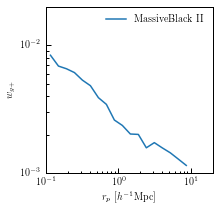

In [16]:
fig  = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rp_bin_centers[:-1], weighted_counts_1[:-1]/counts[:-1], '-')
#plt.plot(rp_bin_centers, weighted_counts_2/counts, '--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.1,20])
plt.xlabel(r'$r_p~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$w_{g+}$')
plt.ylim([0.001,0.02])
plt.legend([l1],['MassiveBlack II'], loc='upper right', fontsize=10, frameon=False)
plt.show()

fig.savefig(PROJECT_DIRECTORY+'shape_correlations/notebooks/'+'galaxy_shape_correlation.pdf', dpi=250)